## Import thư viện

Trong bước đầu tiên, nhóm tiến hành import toàn bộ các thư viện cần thiết để xử lý dữ liệu, trực quan hóa và xây dựng mô hình học máy. Các thư viện chính bao gồm:
- pandas, numpy: xử lý dữ liệu dạng bảng và tính toán số.
- matplotlib, seaborn: trực quan hóa dữ liệu.
- scikit-learn: tách dữ liệu, mô hình Random Forest, tối ưu và đánh giá.
- scipy.stats: dùng trong quá trình tuning.

Đây là bộ thư viện tối thiểu để chạy toàn bộ pipeline dự đoán giá xe Audi.

In [1]:
# ============================================================
# BTL CO3117: Dự đoán giá xe Audi đã qua sử dụng
# Thuật toán: Random Forest Regressor
# Nhóm: CO3117
# ============================================================

# --- 1. IMPORT THƯ VIỆN ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
import warnings

# Tắt cảnh báo không cần thiết để code sạch
warnings.filterwarnings("ignore")

## 2. Tải và tiền xử lý dữ liệu

### 2.1. Tải dữ liệu

Dataset được tải từ file audi.csv chứa thông tin về giá xe Audi cũ.

### 2.2. Làm sạch dữ liệu thô

Qua quan sát ban đầu, nhóm phát hiện dữ liệu tồn tại một số điểm “nhiễu”:

- Một số tên cột chứa khoảng trắng thừa.
- Một số giá trị dạng chuỗi (ví dụ model, transmission) cũng có khoảng trắng thừa.

Để đảm bảo dữ liệu nhất quán, nhóm thực hiện:

1. Xóa khoảng trắng thừa ở tên cột bằng df.columns.str.strip().
2. Duyệt qua các cột dạng object và chuẩn hóa lại bằng df[col].str.strip().

Mục tiêu: tránh lỗi trong quá trình one-hot encoding và xử lý sau này.

In [2]:
# ============================================================
# 2. LOAD DỮ LIỆU VÀ TIỀN XỬ LÝ CƠ BẢN
# ============================================================

def load_and_clean_data(filepath):
    """
    Hàm đọc dữ liệu từ file CSV và làm sạch cơ bản.
    - Loại bỏ khoảng trắng thừa ở tên cột và giá trị chuỗi
    - Trả về DataFrame pandas
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: Không tìm thấy file '{filepath}'")
        print("Hãy tải file 'audi.csv' và đặt vào đúng thư mục.")
        return None

    # Làm sạch tên cột
    df.columns = df.columns.str.strip()

    # Làm sạch dữ liệu chuỗi (string)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.strip()

    print("Dữ liệu đã được load và làm sạch thành công.")
    return df

DATA_FILEPATH = "../data/audi.csv"

df = load_and_clean_data(DATA_FILEPATH)

Dữ liệu đã được load và làm sạch thành công.


## 3. Khám phá dữ liệu (EDA)

Sau khi làm sạch, nhóm tiến hành phân tích tổng quan để hiểu rõ dữ liệu:

### 3.1. Thông tin tổng quan (df.info())

- Dataset có ~10,000 mẫu và 9 cột.
- Không có giá trị bị thiếu (non-null).
- Ba cột dạng chữ: model, transmission, fuelType → cần mã hóa.

### 3.2. Phân bố giá xe

Histogram của biến price cho thấy:

- Phân bố lệch phải (right-skewed).
- Đa phần xe có giá dưới 40,000.

### 3.3. Phân tích quan hệ giữa các biến

- Price vs Year: Xe năm càng mới → giá càng cao → tương quan thuận.
- Price vs Mileage: Xe đi càng nhiều → giá càng giảm → tương quan nghịch.

### 3.4. Ma trận tương quan (heatmap)

Kết quả đáng chú ý:

- Năm sản xuất và giá tương quan dương vừa phải (0.59).
- Quãng đường đã đi và giá tương quan âm vừa mạnh (-0.54).
- Mức tiêu thụ nhiên liệu và giá tương quan âm khá mạnh (-0.60).
- Thuế đường bộ và giá tương quan dương yếu đến vừa (0.36).


--- 3. EDA: Khám phá dữ liệu ---

[Text] Thống kê mô tả:
               year          price        mileage    engineSize
count  10668.000000   10668.000000   10668.000000  10668.000000
mean    2017.100675   22896.685039   24827.244001      1.930709
std        2.167494   11714.841888   23505.257205      0.602957
min     1997.000000    1490.000000       1.000000      0.000000
25%     2016.000000   15130.750000    5968.750000      1.500000
50%     2017.000000   20200.000000   19000.000000      2.000000
75%     2019.000000   27990.000000   36464.500000      2.000000
max     2020.000000  145000.000000  323000.000000      6.300000

[Hình 1] Đang vẽ Phân phối (Histograms)...


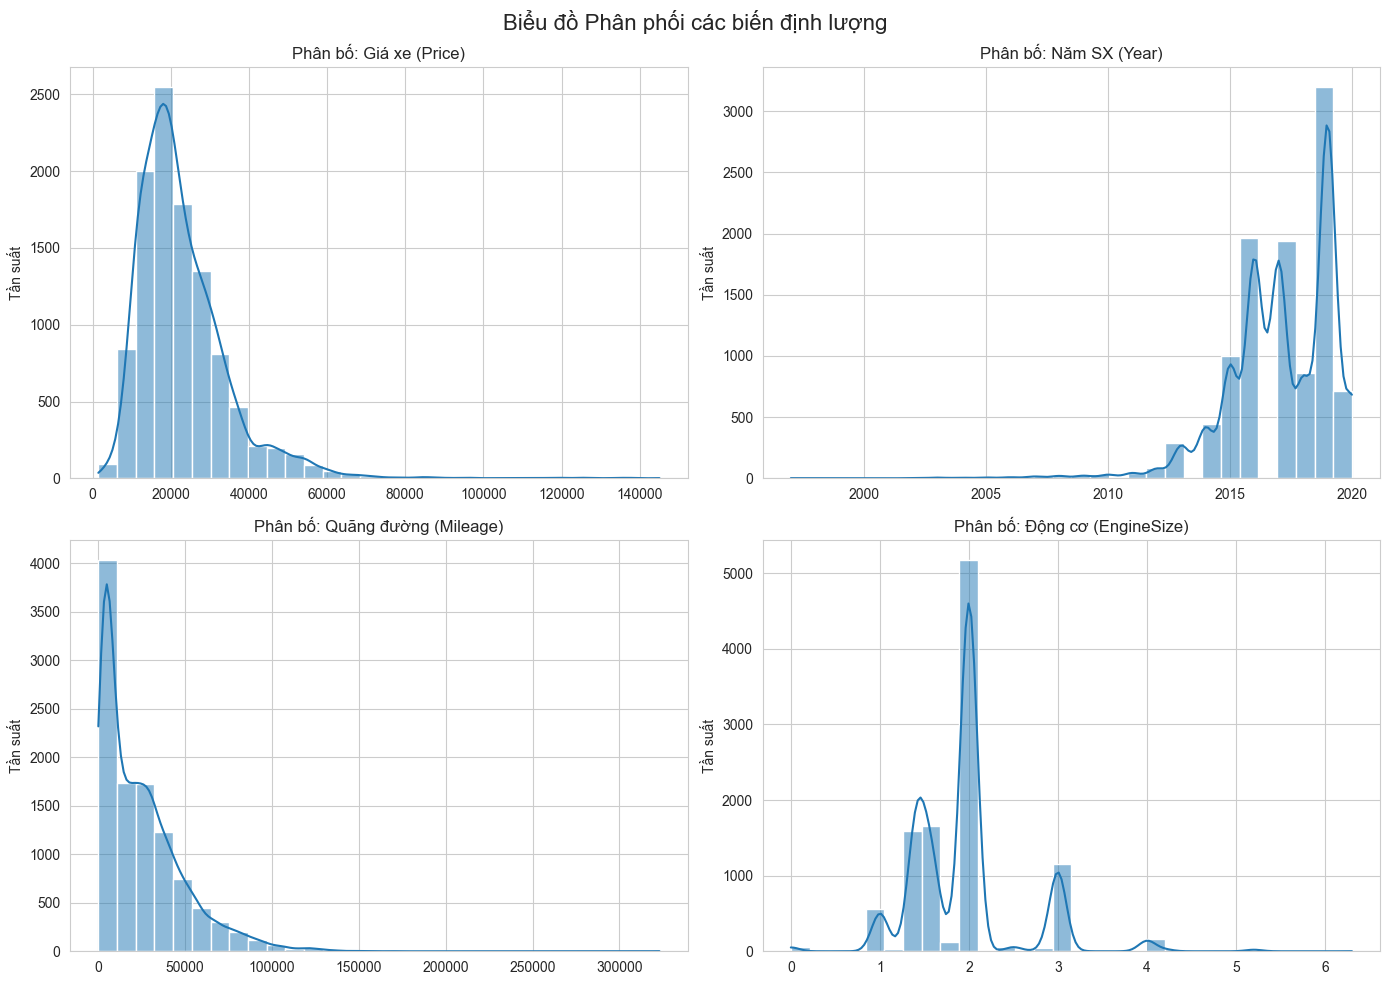


[Hình 2] Boxplots 


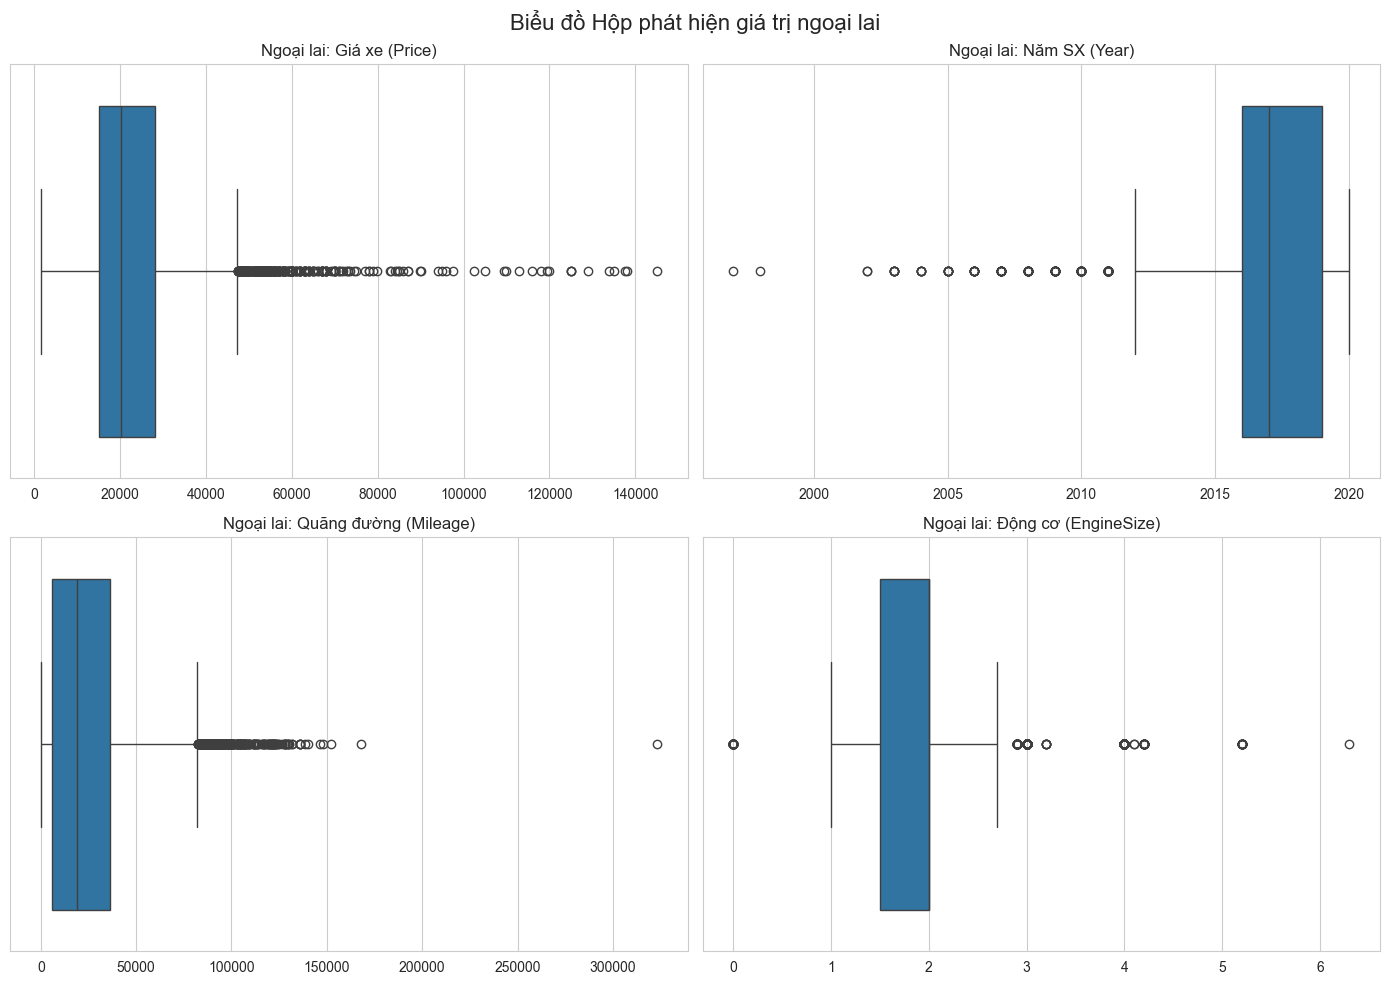


[Hình 3, 4] Scatter plots


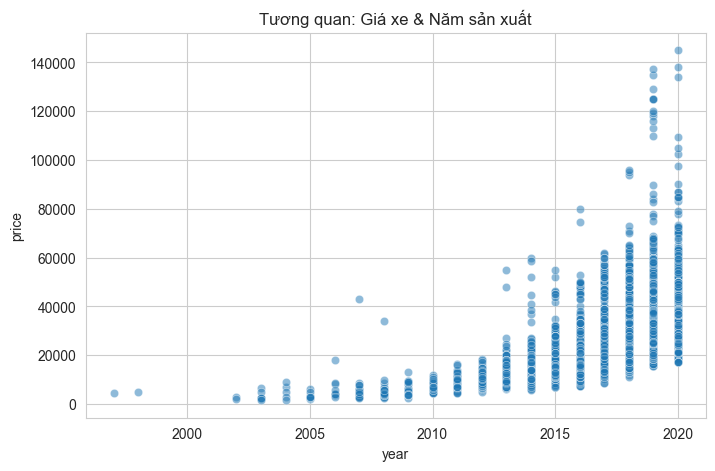

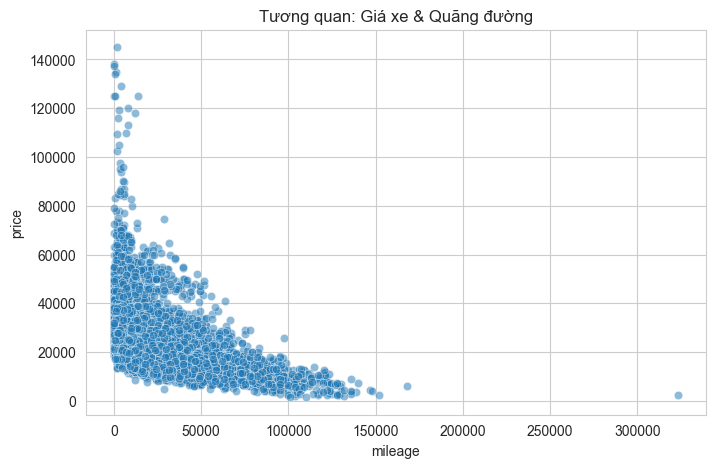


[Hình 5] Heatmap


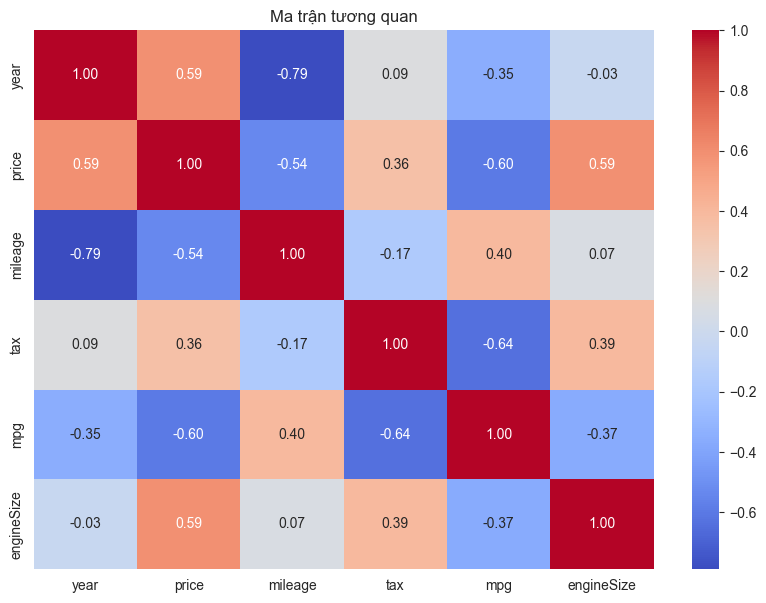


--- Đang tạo hình ảnh bảng thống kê... ---


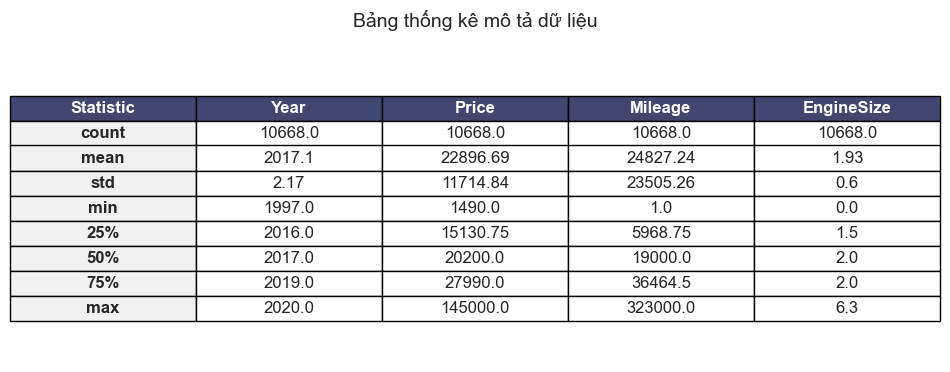

In [ ]:
# ============================================================
# 3. KHÁM PHÁ DỮ LIỆU (EDA)
# ============================================================

def run_eda(df):
    """
    Hàm EDA tối ưu hóa cho báo cáo:
    1. Thống kê mô tả (Text).
    2. Hình 1: Tổng hợp phân phối (4 Histograms).
    3. Hình 2: Tổng hợp ngoại lai (4 Boxplots).
    4. Hình 3, 4: Quan hệ (Scatter).
    5. Hình 5: Tương quan (Heatmap).
    """
    print("\n--- 3. EDA: Khám phá dữ liệu ---")

    # Cài đặt giao diện
    sns.set_style("whitegrid")
    main_color = 'tab:blue' 

    # --- PHẦN 1: TEXT ---
    print("\n[Text] Thống kê mô tả:")
    print(df[['year', 'price', 'mileage', 'engineSize']].describe())

    # Danh sách biến quan trọng
    cols = ['price', 'year', 'mileage', 'engineSize']
    titles = ['Giá xe (Price)', 'Năm SX (Year)', 'Quãng đường (Mileage)', 'Động cơ (EngineSize)']

    # --- PHẦN 2: VẼ 4 HISTOGRAMS (PHÂN BỐ) ---
    print("\n[Hình 1] Đang vẽ Phân phối (Histograms)...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Lưới 2x2 đẹp hơn 4x1
    axes = axes.flatten() # Làm phẳng mảng axes để dễ duyệt vòng lặp

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, bins=30, color=main_color, ax=axes[i])
        axes[i].set_title(f'Phân bố: {titles[i]}')
        axes[i].set_ylabel('Tần suất')
        axes[i].set_xlabel('')
    
    plt.suptitle('Biểu đồ Phân phối các biến định lượng', fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- PHẦN 3: VẼ 4 BOXPLOTS (NGOẠI LAI) ---
    print("\n[Hình 2] Boxplots ")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.boxplot(x=df[col], color=main_color, ax=axes[i])
        axes[i].set_title(f'Ngoại lai: {titles[i]}')
        axes[i].set_xlabel('')
    
    plt.suptitle('Biểu đồ Hộp phát hiện giá trị ngoại lai', fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- PHẦN 4: SCATTER PLOTS ---
    print("\n[Hình 3, 4] Scatter plots")
    
    # Giá vs Năm
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='year', y='price', alpha=0.5, color=main_color)
    plt.title("Tương quan: Giá xe & Năm sản xuất")
    plt.show()

    # Giá vs Mileage
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='mileage', y='price', alpha=0.5, color=main_color)
    plt.title("Tương quan: Giá xe & Quãng đường")
    plt.show()

    # --- PHẦN 5: HEATMAP ---
    print("\n[Hình 5] Heatmap")
    plt.figure(figsize=(10, 7))
    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Ma trận tương quan")
    plt.show()

run_eda(df)

## 4. Tiền xử lý & tạo đặc trưng (Feature Engineering)

Để mô hình có thể đọc dữ liệu dạng chữ, nhóm sử dụng One-Hot Encoding cho 3 cột:
- model
- transmission
- fuelType

Điều này biến dữ liệu dạng chữ thành dữ liệu dạng số (0/1).
Kết quả: số lượng feature tăng từ 9 → hơn 30 cột.

Sau đó dataset được tách thành:
- X: tất cả đặc trưng
- y: biến mục tiêu (price)

In [4]:
# ============================================================
# 4. TIỀN XỬ LÝ DỮ LIỆU & FEATURE ENGINEERING
# ============================================================

def preprocess_data(df):
    """
    - One-Hot Encoding cho các biến categorical
    - Tách dữ liệu thành X (features) và y (target)
    - Trả về danh sách feature names để phân tích quan trọng đặc trưng
    """
    print("\n--- 4. Tiền xử lý dữ liệu ---")

    categorical_cols = ['model', 'transmission', 'fuelType']

    print(f"Số lượng feature ban đầu: {df.shape[1]}")
    df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"Số lượng feature sau khi one-hot encoding: {df_processed.shape[1]}")

    X = df_processed.drop('price', axis=1)
    y = df_processed['price']

    feature_names = X.columns.tolist()

    return X, y, feature_names

# Tiền xử lý & tạo features
X, y, feature_names = preprocess_data(df)


--- 4. Tiền xử lý dữ liệu ---
Số lượng feature ban đầu: 9
Số lượng feature sau khi one-hot encoding: 35


## 5. Huấn luyện mô hình cơ bản (Base Model)

Nhóm sử dụng Random Forest Regressor với bộ tham số mặc định:
- Số lượng cây: 100
- Không giới hạn độ sâu
- Random state cố định để kết quả reproducible

Mục tiêu của mô hình baseline: Tạo chuẩn so sánh trước khi tuning.

In [5]:
# ============================================================
# 5. TRAIN BASE MODEL & EVALUATE
# ============================================================

def train_base_model(X_train, y_train):
    """
    Huấn luyện Random Forest cơ bản với tham số mặc định.
    """
    print("\n--- 5. Huấn luyện Base Random Forest ---")
    rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
    print("Đang huấn luyện base model...")
    rf_base.fit(X_train, y_train)
    print("Huấn luyện base model hoàn tất.")
    return rf_base

# Split dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain size: {X_train.shape[0]} samples, Test size: {X_test.shape[0]} samples")

# Train Base model
base_model = train_base_model(X_train, y_train)


Train size: 8534 samples, Test size: 2134 samples

--- 5. Huấn luyện Base Random Forest ---
Đang huấn luyện base model...
Huấn luyện base model hoàn tất.


## 6. Đánh giá mô hình cơ bản

Đánh giá dựa trên 2 chỉ số chính:
- RMSE: độ lệch dự đoán.
- R²: mức độ mô hình giải thích được biến price.

Ngoài ra, biểu đồ Actual vs Predicted cho thấy mức độ khớp của mô hình.


--- Đánh giá Base Model ---
RMSE (Root Mean Squared Error): 2281.34
R2 Score (Hệ số xác định): 0.9656 (tương đương 96.56%)


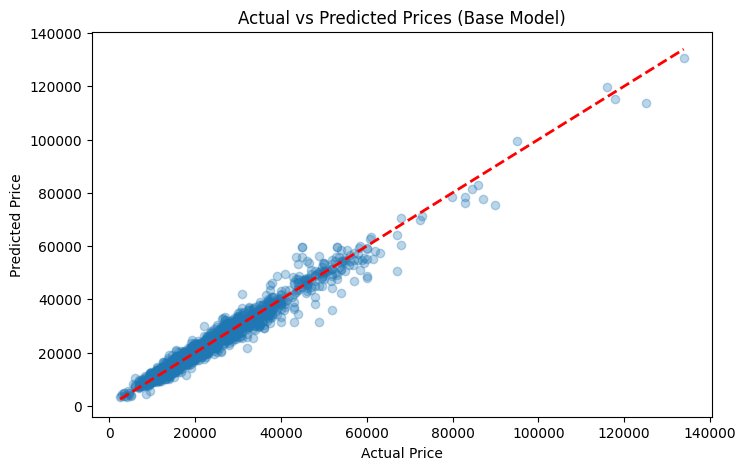

In [6]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Đánh giá model trên tập test:
    - RMSE
    - R2 score
    - Biểu đồ Actual vs Predicted
    """
    print(f"\n--- Đánh giá {model_name} ---")

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"R2 Score (Hệ số xác định): {r2:.4f} (tương đương {r2*100:.2f}%)")

    plt.figure(figsize=(8,5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"Actual vs Predicted Prices ({model_name})")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.show()

evaluate_model(base_model, "Base Model", X_test, y_test)

## 7. Tuning Hyperparameter (RandomizedSearchCV)

Để cải thiện mô hình, nhóm dùng RandomizedSearchCV để tìm:
- n_estimators
- max_depth
- min_samples_split
- min_samples_leaf
- max_features

Chạy trên 3-fold cross validation.

Mục tiêu: tối ưu độ chính xác trong thời gian hợp lý.

In [7]:
# ============================================================
# 7. HYPERPARAMETER TUNING
# ============================================================

def tune_model(X_train, y_train):
    """
    Tối ưu tham số Random Forest bằng RandomizedSearchCV.
    - Thử nhiều tổ hợp tham số ngẫu nhiên
    - Trả về model tốt nhất
    """
    print("\n--- 6. Hyperparameter Tuning ---")

    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 1.0]
    }

    rf_random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    print("Bắt đầu tìm tham số tốt nhất... (có thể mất vài phút)")
    rf_random_search.fit(X_train, y_train)

    print("Tuning hoàn tất.")
    print(f"Tham số tốt nhất tìm được: {rf_random_search.best_params_}")
    return rf_random_search.best_estimator_

# Hyperparameter tuning
tuned_model = tune_model(X_train, y_train)


--- 6. Hyperparameter Tuning ---
Bắt đầu tìm tham số tốt nhất... (có thể mất vài phút)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning hoàn tất.
Tham số tốt nhất tìm được: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 121}


## 8. Đánh giá mô hình đã tuning

Sau khi tối ưu, mô hình được đánh giá lại bằng:
- RMSE
- R²

Biểu đồ Actual vs Predicted

So sánh với base model để xem tuning có hiệu quả hay không.


--- Đánh giá Tuned Model ---
RMSE (Root Mean Squared Error): 2342.08
R2 Score (Hệ số xác định): 0.9637 (tương đương 96.37%)


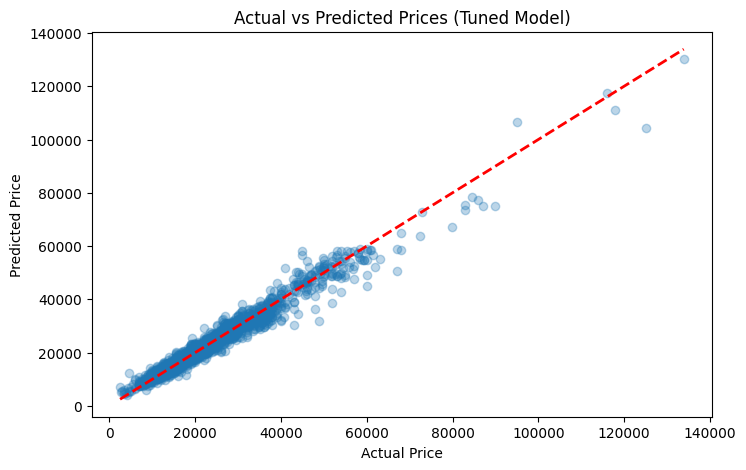

In [8]:
evaluate_model(tuned_model, "Tuned Model", X_test, y_test)

## 9. Phân tích Feature Importance

Random Forest cho phép trích xuất độ quan trọng của từng đặc trưng.
Nhóm hiển thị top 15 đặc trưng quan trọng nhất giúp:
- Hiểu mô hình ra quyết định như thế nào
- Xác định biến nào ảnh hưởng mạnh nhất đến giá xe

Thông thường các biến quan trọng nhất là:
- year
- mileage
- engineSize
- một số mã model nhất định


--- 7. Feature Importance ---


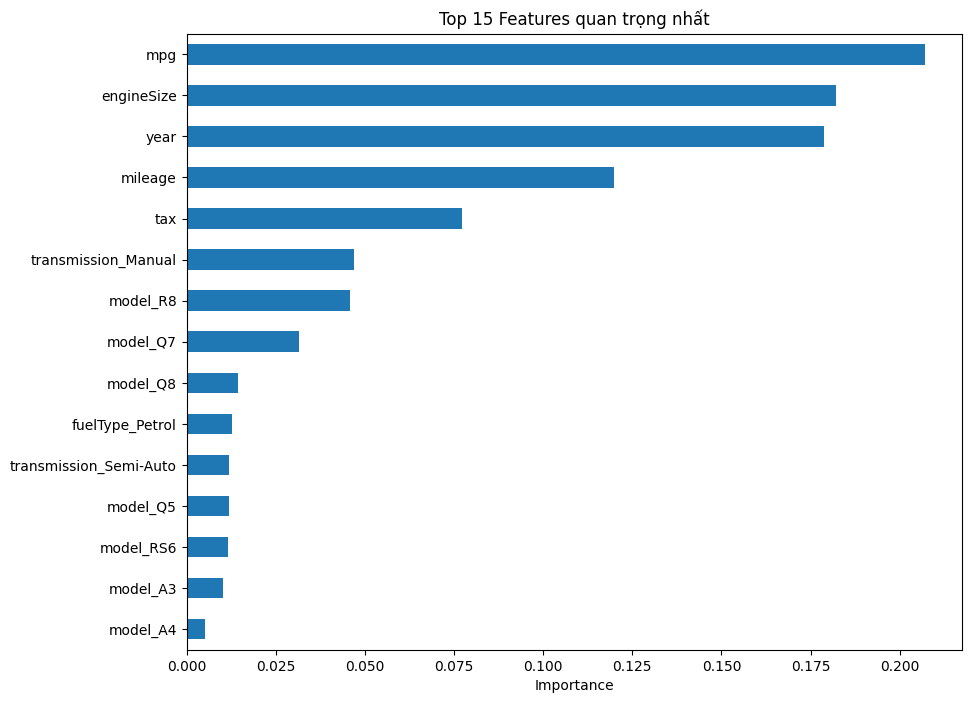

In [9]:
# ============================================================
# 9. FEATURE IMPORTANCE
# ============================================================

def show_feature_importance(model, feature_names):
    """
    Vẽ biểu đồ top 15 features quan trọng nhất.
    """
    print("\n--- 7. Feature Importance ---")

    importances = model.feature_importances_
    feat_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10,8))
    feat_importance_df.head(15).plot(kind='barh')
    plt.title("Top 15 Features quan trọng nhất")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.show()

show_feature_importance(tuned_model, feature_names)

In [10]:
print("\n--- ML Pipeline Complete ---")


--- ML Pipeline Complete ---
